In [1]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import random
from time import time



DATADIR='C:/Users/madhu_g/Desktop/Madhu Jogee/Mini Project/COVID-19_Radiography_Dataset'

CATEGORIES = ["COVID/G4P16","Normal/G4P16"]

IMG_SIZE = 128

num_epoch =100

batch_size=128


os.chdir(DATADIR)

DATA = []

In [2]:

for category in CATEGORIES:
    path=os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)

    for img in tqdm(os.listdir(path)):

        try:
            img_array = cv2.imread(os.path.join(path,img))
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            DATA.append([img_array, class_num])

        except Exception as e:
            pass

random.shuffle(DATA)

100%|███████████████████████████████████████████████████████████████████████████| 10192/10192 [00:57<00:00, 178.37it/s]


In [3]:
from tensorflow.keras.utils import to_categorical
X = []

y = []

for features,label in DATA:
    X.append(features)
    y.append(label)

print(len(X))

print(len(X[0]))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

y = np.array(to_categorical(y))



13808
128


In [4]:
print(X.shape,y.shape)
print(y[:10])

(13808, 128, 128, 3) (13808, 2)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [5]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=50,stratify=y)



print("Training Samples",x_train.shape,y_train.shape)
print("Testing Samples",x_test.shape,y_test.shape)



Training Samples (12427, 128, 128, 3) (12427, 2)
Testing Samples (1381, 128, 128, 3) (1381, 2)


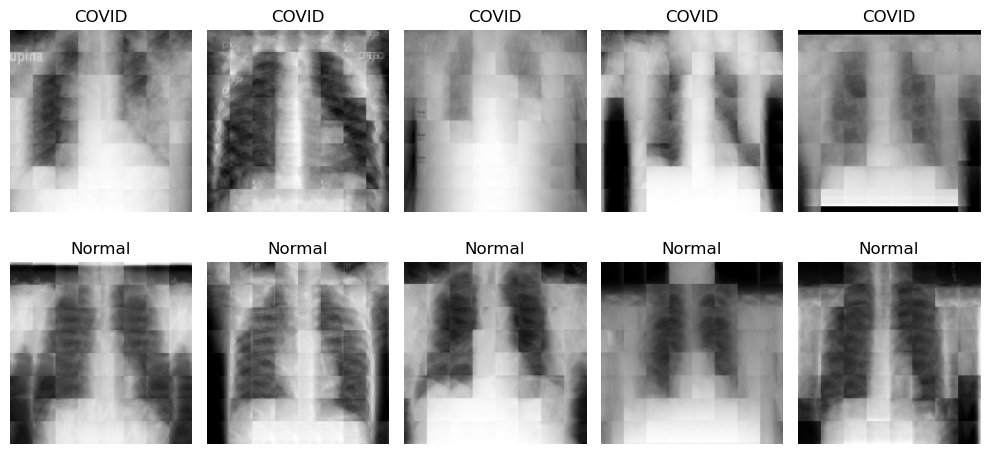

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random



def load_images_from_categories(categories, num_samples=5):
    data = []
    for category in categories:
        path = os.path.join(DATADIR, category)
        images = os.listdir(path)
        random_images = random.sample(images, num_samples)  # Randomly select images
        for img_name in random_images:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            label = category.split('/')[0]  # Get the label (COVID or Normal)
            data.append((img, label))
    return data

# Load images
images_data = load_images_from_categories(CATEGORIES)

# Visualize images
def visualize_images(images_data):
    plt.figure(figsize=(10, 5))
    for i, (img, label) in enumerate(images_data):
        plt.subplot(2, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)  # Show the correct label
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize 5 images from each category
visualize_images(images_data)


In [7]:
del DATA
del X
del y

In [8]:
def squash(x,axis=-1):
  s_squared_norm=tf.reduce_sum(tf.square(x),axis=axis,keepdims=True)
  scale=s_squared_norm/(1+s_squared_norm)/tf.sqrt(s_squared_norm+tf.keras.backend.epsilon())
  return scale*x

In [9]:
def loss_fn(y_true, y_pred):
    L = y_true * tf.square(tf.maximum(0., 0.9 - y_pred)) + \
        0.45 * (1 - y_true) * tf.square(tf.maximum(0., y_pred - 0.1))
    return tf.reduce_mean(tf.reduce_sum(L, axis=1))

In [10]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, Reshape, Dense, Multiply, Lambda, Flatten,BatchNormalization,PReLU,Dropout,Activation
from keras import regularizers
from keras.regularizers import l2

input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

cnn1 = Conv2D(32, (3,3), 2, padding='same', activation=PReLU(),name="cnn1",kernel_regularizer=l2(1e-4))(input_layer)
b_cnn1=BatchNormalization()(cnn1)

cnn2 = Conv2D(32, (3,3), 2, padding='same', activation=PReLU(),name="cnn2")(b_cnn1)
b_cnn2=BatchNormalization()(cnn2)

cnn3 = Conv2D(64, (3,3), 2, padding='same', activation=PReLU(),name="cnn3")(b_cnn2)
b_cnn3=BatchNormalization()(cnn3)

cnn4 = Conv2D(32, (3,3), 2, padding='same', activation=PReLU(),name="cnn4")(b_cnn3)
b_cnn4=BatchNormalization()(cnn4)

cnn5 = Conv2D(32, (3,3), 2, padding='same', activation=PReLU(),name="cnn5")(b_cnn4)
b_cnn5=BatchNormalization()(cnn5)

b_cnn7 = Lambda(squash, output_shape=lambda s: s)(b_cnn5)


primary_caps = Reshape((-1, 8))(b_cnn7)



primary_caps=Dropout(0.75)(primary_caps)
primary_caps = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='swish')(primary_caps)
primary_caps=PReLU()(primary_caps)


routing_weights1 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='relu')(primary_caps)
weighted_caps1 = Multiply()([primary_caps, routing_weights1])
weighted_caps1=PReLU()(weighted_caps1)
weighted_caps1=Dropout(0.75)(weighted_caps1)


routing_weights2 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='relu')(weighted_caps1)
weighted_caps2 = Multiply()([primary_caps, routing_weights2])
weighted_caps2=PReLU()(weighted_caps2)
weighted_caps2=Dropout(0.75)(weighted_caps2)


routing_weights3 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='relu')(weighted_caps2)
weighted_caps3 = Multiply()([primary_caps, routing_weights3])
weighted_caps3=PReLU()(weighted_caps3)


routing_weights4 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='relu')(weighted_caps3)
weighted_caps4 = Multiply()([primary_caps, routing_weights4])
weighted_caps4=PReLU()(weighted_caps4)


routing_weights5 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='relu')(weighted_caps4)
weighted_caps5 = Multiply()([primary_caps, routing_weights5])
weighted_caps5=PReLU()(weighted_caps5)


flattened = Flatten()(weighted_caps5)
flattened = Dropout(0.75)(flattened)

dense1 = Dense(64,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='relu',kernel_regularizer=l2(1e-4))(flattened)
dense1 = Dropout(0.7)(dense1)
dense2 = Dense(256,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='relu',kernel_regularizer=l2(1e-4))(dense1)
dense2 = Dropout(0.75)(dense2)

output_layer = Dense(2,kernel_initializer='lecun_normal', bias_initializer='zeros', activation='softmax',kernel_regularizer=l2(1e-4))(dense2)

model2 = Model(inputs=input_layer, outputs=output_layer)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cnn1 (Conv2D)                  (None, 64, 64, 32)   131968      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['cnn1[0][0]']                   
 alization)                                                                                       
                                                                                              

In [11]:
from keras.optimizers import Nadam,Adam

model2.compile(optimizer=Adam(learning_rate=3e-04),loss=loss_fn,metrics=['acc'])

In [12]:
from keras.backend import clear_session
clear_session()

In [13]:
start_time = time()
history2=model2.fit(x_train,y_train,epochs=num_epoch,batch_size=batch_size,verbose=1,validation_data=(x_test,y_test))
training_time = time() - start_time

Epoch 1/100
98/98 [==============================] - 8s 45ms/step - loss: 0.2269 - acc: 0.7335 - val_loss: 0.2048 - val_acc: 0.7379
Epoch 2/100
98/98 [==============================] - 4s 40ms/step - loss: 0.1930 - acc: 0.7382 - val_loss: 0.2004 - val_acc: 0.7379
Epoch 3/100
98/98 [==============================] - 4s 40ms/step - loss: 0.1805 - acc: 0.7382 - val_loss: 0.1950 - val_acc: 0.7379
Epoch 4/100
98/98 [==============================] - 4s 40ms/step - loss: 0.1690 - acc: 0.7382 - val_loss: 0.1829 - val_acc: 0.7379
Epoch 5/100
98/98 [==============================] - 4s 40ms/step - loss: 0.1605 - acc: 0.7385 - val_loss: 0.1737 - val_acc: 0.7379
Epoch 6/100
98/98 [==============================] - 4s 42ms/step - loss: 0.1514 - acc: 0.7487 - val_loss: 0.1655 - val_acc: 0.8038
Epoch 7/100
98/98 [==============================] - 4s 42ms/step - loss: 0.1437 - acc: 0.7890 - val_loss: 0.1400 - val_acc: 0.8255
Epoch 8/100
98/98 [==============================] - 4s 42ms/step - loss: 0.

In [14]:
start_time = time()
test_loss,test_acc = model2.evaluate(x_test,  y_test, verbose=2)
print('Test Loss: %.3f, Test Accuracy: %.3f' % (test_loss, test_acc))
testing_time = time()-start_time

44/44 - 0s - loss: 0.2237 - acc: 0.7502 - 469ms/epoch - 11ms/step
Test Loss: 0.224, Test Accuracy: 0.750


In [15]:
print("Training Time ",training_time)
print("Testing TIme ",testing_time)

Training Time  401.0781855583191
Testing TIme  0.5293364524841309


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


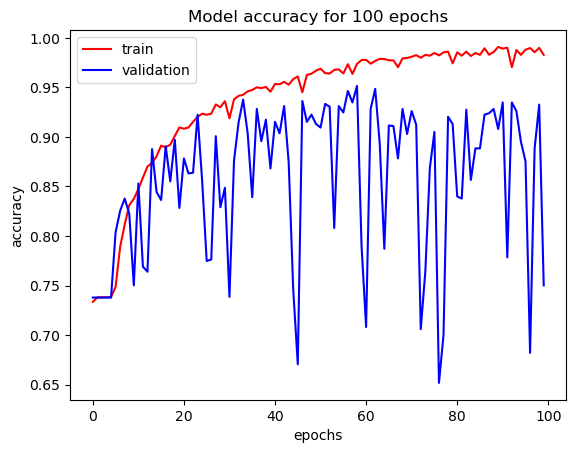

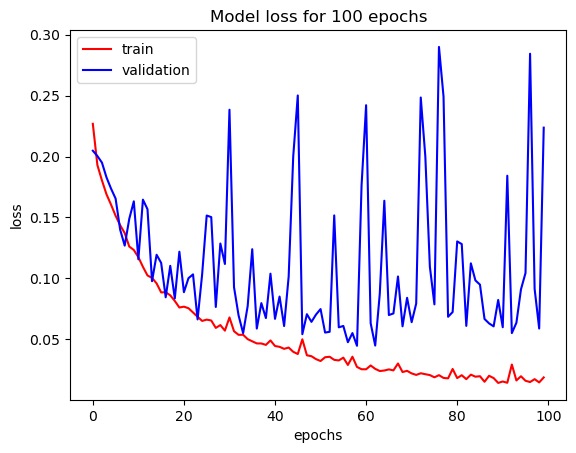

In [16]:
print(history2.history.keys())

import matplotlib.pyplot as plt


plt.plot(history2.history['acc'],color='r')
plt.plot(history2.history['val_acc'],color='b')
plt.title('Model accuracy for {0} epochs'.format(num_epoch))
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()



plt.plot(history2.history['loss'],color='r')
plt.plot(history2.history['val_loss'],color='b')
plt.title('Model loss for {0} epochs'.format(num_epoch))
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()

389/389 [==============================] - 4s 9ms/step
AUC Train: 0.9590136561624195
44/44 [==============================] - 0s 10ms/step
AUC Test: 0.9218793205341604


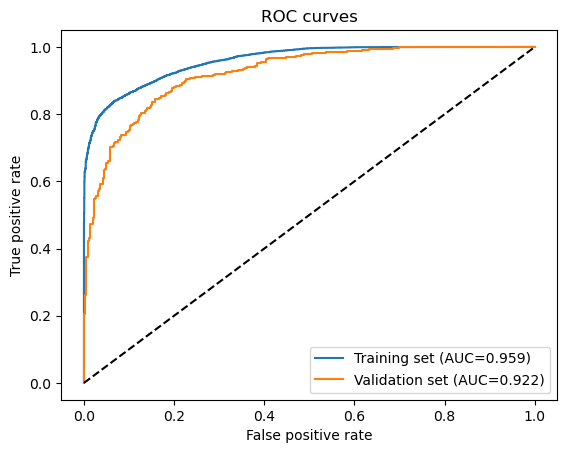

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Ensure y_train is in binary format
# If y_train is multilabel, you might need to use the appropriate index or convert it to binary
if y_train.shape[1] > 1:
    y_train_binary = np.argmax(y_train, axis=1)  # Convert to binary labels if needed
else:
    y_train_binary = y_train.flatten()  # Make sure it's 1D

# Calculate the predicted probabilities
y_train_pred_proba = model2.predict(x_train)

# Calculate ROC curve and AUC
fpr_train, tpr_train, _ = roc_curve(y_train_binary, y_train_pred_proba[:, 1])
auc_train = roc_auc_score(y_train_binary, y_train_pred_proba[:, 1])

print("AUC Train:", auc_train)

# Repeat the same for the test set
if y_test.shape[1] > 1:
    y_test_binary = np.argmax(y_test, axis=1)  # Convert to binary labels if needed
else:
    y_test_binary = y_test.flatten()  # Make sure it's 1D

y_test_pred_proba = model2.predict(x_test)

fpr_val, tpr_val, _ = roc_curve(y_test_binary, y_test_pred_proba[:, 1])
auc_val = roc_auc_score(y_test_binary, y_test_pred_proba[:, 1])

print("AUC Test:", auc_val)

# Plotting the ROC curves
plt.plot(fpr_train, tpr_train, label='Training set (AUC={:.3f})'.format(auc_train))
plt.plot(fpr_val, tpr_val, label='Validation set (AUC={:.3f})'.format(auc_val))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves')
plt.legend()
plt.show()


44/44 [==============================] - 0s 10ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.94      0.66       362
           1       0.97      0.68      0.80      1019

    accuracy                           0.75      1381
   macro avg       0.74      0.81      0.73      1381
weighted avg       0.85      0.75      0.77      1381



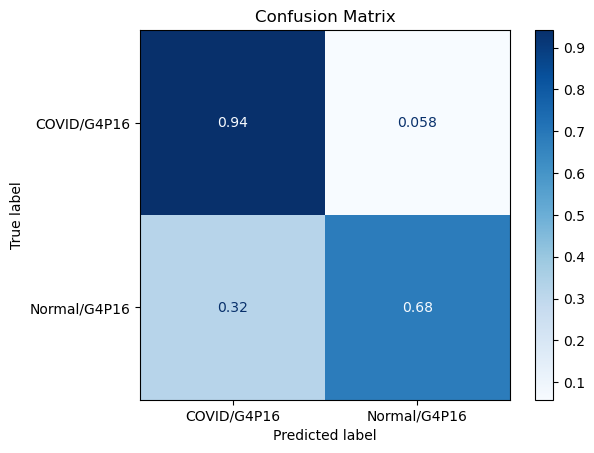

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict probabilities for the test set
y_test_pred_proba = model2.predict(x_test)

# Convert predictions to class labels
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Ensure y_test is in the right format (1D array for binary or single-label multiclass)
if y_test.shape[1] > 1:
    y_test_binary = np.argmax(y_test, axis=1)  # Convert multilabel to single-label
else:
    y_test_binary = y_test.flatten()  # Make sure it's 1D

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_test_pred)

# Normalize confusion matrix if needed
conf_matrix_values = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Print classification report
c_r = classification_report(y_test_binary, y_test_pred)
print("Classification Report:")
print(c_r)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_values, display_labels=CATEGORIES)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [19]:
model2.save(DATADIR+'/Models/R5G4P16model.h5')